In [ ]:
import os as os
import numpy as np
import pandas as pd
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.fft import fft

In [3]:
# Size of input to 1D CNN or number of complex samples being fed to 1D CNN (should be same as bin2hdf5.py)
buf = 128

# Percentage of dataset that will be used for testing
test_size = 0.1

# Seed used for shuffling dataset
seed = 42

# Filepath containing directory with converted .h5 files
h5_folder_fp = "data/h5/"
folder = os.listdir(h5_folder_fp)
folder.sort()

# Generate dummy arrays to be contain entire dataset and dataset labels (can also use list and convert to np.array later)
dataset_labels = np.zeros((1, 4))
dataset = np.zeros((1, buf, 2))

for file in folder: 
    if not os.path.isdir(h5_folder_fp + file):
        # Open .h5 folder and extract data
        f = h5py.File(h5_folder_fp + file, 'r')
        name = os.path.splitext(file)[0]
        data = f[name][()]

        # Append samples from current file to dataset
        dataset = np.concatenate((dataset, data))

        # Generates the multi-hot encoded labels from the file name
        label = list(name.split('_')[0])    # Take part of filename that contains labels
        label = list(map(int, label))       # Convert string to multi-hot list
        label = [label] * data.shape[0]     # Generate label for each training sample in file
        label = np.array(label, dtype='i')  # Convert list of labels to np.array
        dataset_labels = np.concatenate((dataset_labels, label))    # Append to labels for entire dataset

f.close()

# Delete first entry of arrays as they contain zeros
dataset = np.delete(dataset, 0, 0)
dataset_labels = np.delete(dataset_labels, 0, 0)

In [4]:
# Shuffle dataset and split into training and testing samples
X_train, X_test, y_train, y_test = train_test_split(
    dataset, 
    dataset_labels, 
    test_size=test_size, 
    random_state=seed
)

# Convert numpy arrays to DataFrames (reshape because data is 3 dimensional and DataFrames only accept 2D data since it is a table)
X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0], -1))
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], -1))
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

In [5]:
if False:
    # Save test set using pandas
    with pd.HDFStore('./data/sdr_wifi_test.hdf5', 'w') as f_test:
        f_test.put('X', X_test_df)
        f_test.put('y', y_test_df)

    # Save train set using pandas
    with pd.HDFStore('./sdr_wifi_train.hdf5', 'w') as f_train:
        f_train.put('X', X_train_df)
        f_train.put('y', y_train_df)

In [6]:
if False:
    # Read test set
    with pd.HDFStore('./data/sdr_wifi_test.hdf5', 'r') as f_test:
        X_test_df = f_test.get('X')
        y_test_df = f_test.get('y')

    # Read train set
    with pd.HDFStore('./sdr_wifi_train.hdf5', 'r') as f_train:
        X_train_df = f_train.get('X')
        y_train_df = f_train.get('y')

In [7]:
# Extract real and imaginary parts
X_train_real = X_train_df.iloc[:, ::2].values  # Real parts
X_train_imag = X_train_df.iloc[:, 1::2].values  # Imaginary parts

X_test_real = X_test_df.iloc[:, ::2].values  # Real parts
X_test_imag = X_test_df.iloc[:, 1::2].values  # Imaginary parts

# Optionally, create additional features like magnitude and phase
X_train_magnitude = np.sqrt(X_train_real**2 + X_train_imag**2)
X_train_phase = np.arctan2(X_train_imag, X_train_real)

X_test_magnitude = np.sqrt(X_test_real**2 + X_test_imag**2)
X_test_phase = np.arctan2(X_test_imag, X_test_real)

# Combine features into a single DataFrame
X_train_features = np.hstack([X_train_real, X_train_imag, X_train_magnitude, X_train_phase])
X_test_features = np.hstack([X_test_real, X_test_imag, X_test_magnitude, X_test_phase])

# Convert to DataFrame
X_train_features_df = pd.DataFrame(X_train_features)
X_test_features_df = pd.DataFrame(X_test_features)

# Now X_train_features_df and X_test_features_df can be used as input to your model
print(X_train_features_df.shape)
print(X_test_features_df.shape)

(287971, 512)
(31997, 512)


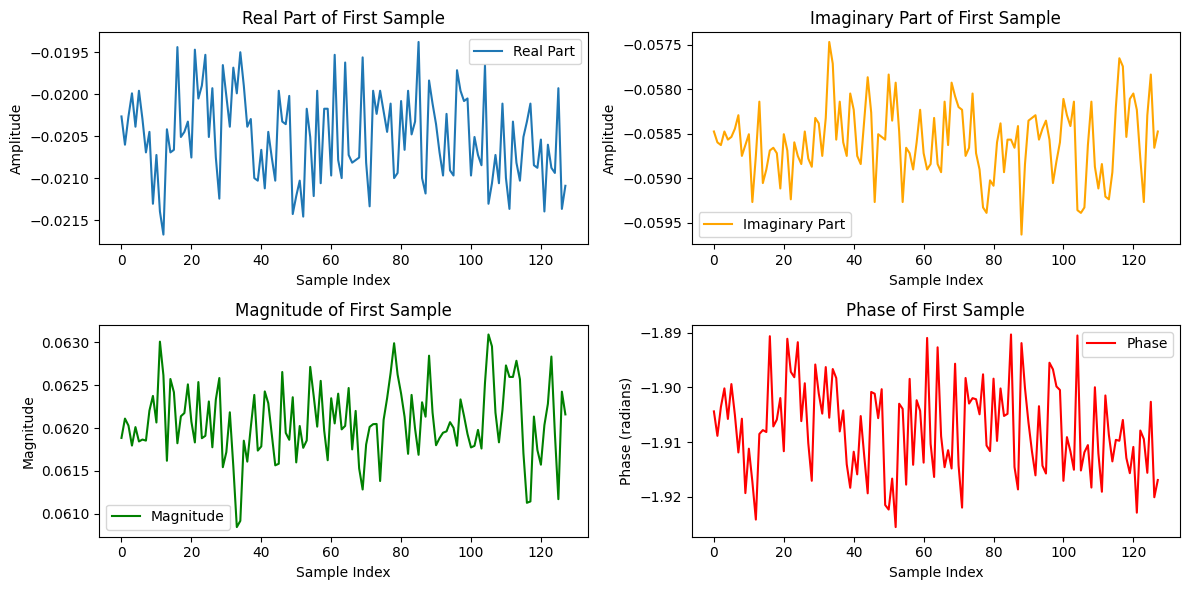

In [8]:
# Plot real and imaginary parts
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(X_train_real[0], label='Real Part')
plt.title('Real Part of First Sample')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(X_train_imag[0], label='Imaginary Part', color='orange')
plt.title('Imaginary Part of First Sample')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()

# Plot magnitude and phase
plt.subplot(2, 2, 3)
plt.plot(X_train_magnitude[0], label='Magnitude', color='green')
plt.title('Magnitude of First Sample')
plt.xlabel('Sample Index')
plt.ylabel('Magnitude')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(X_train_phase[0], label='Phase', color='red')
plt.title('Phase of First Sample')
plt.xlabel('Sample Index')
plt.ylabel('Phase (radians)')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Perform FFT Analysis for 4 channels

# Reshape data into 4 channels (128 samples per channel)
channel_size = X_train_df.shape[1] // 4
reshaped_data = X_train_df.values.reshape(X_train_df.shape[0], 4, -1)

# Apply FFT to each channel
fft_data = fft(reshaped_data, axis=2)

# Calculate signal strength for each channel
magnitude_spectrum = np.abs(fft_data)

# Convert to power (square of magnitude)
power = magnitude_spectrum ** 2

# Normalize power to avoid extremely high or low values
normalized_power = power / np.max(power)

# Convert to dBm
dbm_spectrum = 10 * np.log10(normalized_power + 1e-10)  # Added small constant to avoid log(0)

# Average the dBm spectrum across frequency bins for each channel
channel_strength_dbm = np.mean(dbm_spectrum, axis=2)

# Create DataFrame with 4 channels
channel_df = pd.DataFrame(
    channel_strength_dbm,
    columns=['Channel_1_dBm', 'Channel_2_dBm', 'Channel_3_dBm', 'Channel_4_dBm']
)

# Add time index
channel_df.index = pd.Index(range(len(channel_df)), name='Time')

# Display first few rows
channel_df.head()

,Channel_1_dBm,Channel_2_dBm,Channel_3_dBm,Channel_4_dBm
Time,,,,
0,-66.341428,-64.704363,-65.826255,-64.775770
1,-67.136814,-66.273139,-64.811429,-64.586444
2,-34.462642,-32.385677,-35.841384,-31.101614
3,-30.393354,-27.843437,-30.070414,-28.504396
4,-64.844500,-62.921261,-63.445776,-63.056583


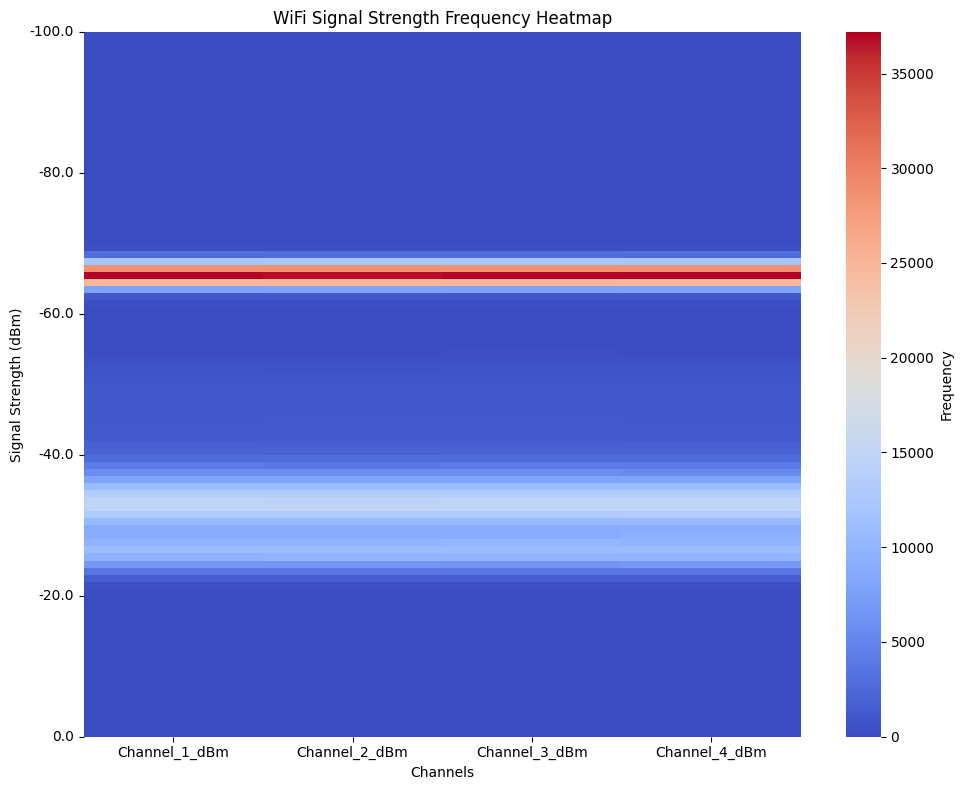

In [31]:
# Define the number of bins for the histogram
num_bins = 100

# Create a 2D histogram
hist_data = np.zeros((num_bins, len(channel_df.columns)))

# Bin edges for dBm values
bin_edges = np.linspace(-100, 0, num_bins + 1)

# Populate the histogram data
for i, column in enumerate(channel_df.columns):
    hist_data[:, i], _ = np.histogram(channel_df[column], bins=bin_edges)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    data=hist_data, 
    cmap='coolwarm',
    cbar_kws={'label': 'Frequency'},
    xticklabels=channel_df.columns,
    yticklabels=np.round(bin_edges[:-1], 1)
)

# Customize y-axis labels to show every 20 or 30 dBm
yticks = np.arange(0, num_bins + 1, num_bins // 5)  # Adjust the step for desired label frequency
ytick_labels = np.round(bin_edges[yticks], 1)

plt.yticks(yticks, ytick_labels)

# Customize plot
plt.title('WiFi Signal Strength Frequency Heatmap')
plt.xlabel('Channels')
plt.ylabel('Signal Strength (dBm)')

# Show plot
plt.tight_layout()
plt.show()